# combine FEMA zipcode catalog with FSF data
In this notebook we combine the FEMA zipcode grouped catalog from `make_fema_zipcode` with the First Street Foundation flooding data

In [1]:
import os
import numpy as np
import astropy.table as aTable

In [2]:
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## read FEMA zipcode grouped catalog

In [3]:
fema = aTable.Table.read('/Users/chahah/data/noah/fema.zipcode.csv', format='csv')
print(len(fema))

213680


In [4]:
fema[:5]

reportedZipcode,yearOfLoss,monthOfLoss,state,longitude,latitude,crs_treat,communityRatingSystemDiscount,primaryResidence,policyCount,amountPaidOnBuildingClaim,amountPaidOnContentsClaim,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,amountPaidOnTotalClaim,totalTotalInsuranceCoverage
int64,int64,int64,str2,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64
601,1992,1,PR,-66.7,18.2,0.0,11.0,0.0,1.0,1106.92,0.0,14600,0,1106.92,14600
601,1992,10,PR,nan,nan,0.0,11.0,0.0,2.0,764.89,4731.0,14000,9000,5495.889999999999,23000
601,1993,5,PR,nan,nan,0.0,11.0,0.0,4.0,3131.57,6839.5,14000,30500,9971.07,44500
601,1998,9,PR,-66.7,18.2,0.0,11.0,0.0,1.0,32150.0,0.0,500000,0,32150.0,500000
601,2003,11,PR,-66.7,18.2,0.0,11.0,1.0,2.0,4719.68,3318.5,20000,7800,8038.179999999999,27800


In [5]:
fema['zipcode'] = fema['reportedZipcode']

## read FSF zipcode level dataset

In [6]:
fsf = aTable.Table.read("/Users/chahah/data/noah/01_DATA/Climate_Risk_Statistics/v1.2/Zip_level_risk_FEMA_FSF_v1.2.csv")
print(len(fsf))

32162


In [7]:
fsf[:5]

zipcode,count_property,count_fema_sfha,pct_fema_sfha,count_fs_risk_2020_5,pct_fs_risk_2020_5,count_fs_risk_2050_5,pct_fs_risk_2050_5,count_fs_risk_2020_100,pct_fs_risk_2020_100,count_fs_risk_2050_100,pct_fs_risk_2050_100,count_fs_risk_2020_500,pct_fs_risk_2020_500,count_fs_risk_2050_500,pct_fs_risk_2050_500,pct_fs_fema_difference_2020,avg_risk_score_all,avg_risk_score_2_10,avg_risk_fsf_2020_100,avg_risk_fsf_2020_500,avg_risk_score_sfha,avg_risk_score_no_sfha,count_floodfactor1,count_floodfactor2,count_floodfactor3,count_floodfactor4,count_floodfactor5,count_floodfactor6,count_floodfactor7,count_floodfactor8,count_floodfactor9,count_floodfactor10
int64,int64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
1001,5343,499,9.3,574,10.7,673,12.6,1208,22.6,1228,23.0,1478,27.7,1530,28.6,13.3,2.82,7.34,8.34,7.51,9.65,2.11,3813,52,104,122,40,279,234,15,144,540
1002,7048,80,1.1,194,2.8,204,2.9,497,7.1,513,7.3,654,9.3,670,9.5,5.9,1.53,6.6,7.61,6.7,5.9,1.48,6378,15,53,87,34,172,94,14,98,103
1003,11,0,0.0,0,0.0,0,0.0,1,9.1,1,9.1,2,18.2,2,18.2,9.1,1.64,4.5,6.0,4.5,--,1.64,9,0,1,0,0,1,0,0,0,0
1005,2981,0,0.0,207,6.9,220,7.4,403,13.5,412,13.8,476,16.0,483,16.2,13.5,2.02,7.31,8.0,7.39,--,2.02,2498,7,20,40,20,100,74,18,104,100
1007,6450,60,0.9,169,2.6,172,2.7,433,6.7,451,7.0,547,8.5,566,8.8,5.8,1.5,6.68,7.61,6.84,4.67,1.47,5884,18,45,45,29,164,74,16,94,81


## combine the FEMA and FSF dataset

In [8]:
comb = aTable.join(fema, fsf, keys='zipcode', join_type='left')

In [9]:
comb[::1000][:20]

reportedZipcode,yearOfLoss,monthOfLoss,state,longitude,latitude,crs_treat,communityRatingSystemDiscount,primaryResidence,policyCount,amountPaidOnBuildingClaim,amountPaidOnContentsClaim,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,amountPaidOnTotalClaim,totalTotalInsuranceCoverage,zipcode,count_property,count_fema_sfha,pct_fema_sfha,count_fs_risk_2020_5,pct_fs_risk_2020_5,count_fs_risk_2050_5,pct_fs_risk_2050_5,count_fs_risk_2020_100,pct_fs_risk_2020_100,count_fs_risk_2050_100,pct_fs_risk_2050_100,count_fs_risk_2020_500,pct_fs_risk_2020_500,count_fs_risk_2050_500,pct_fs_risk_2050_500,pct_fs_fema_difference_2020,avg_risk_score_all,avg_risk_score_2_10,avg_risk_fsf_2020_100,avg_risk_fsf_2020_500,avg_risk_score_sfha,avg_risk_score_no_sfha,count_floodfactor1,count_floodfactor2,count_floodfactor3,count_floodfactor4,count_floodfactor5,count_floodfactor6,count_floodfactor7,count_floodfactor8,count_floodfactor9,count_floodfactor10
int64,int64,int64,str2,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,int64,int64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
601,1992,1,PR,-66.7,18.2,0.0,11.0,0.0,1.0,1106.92,0.0,14600,0,1106.92,14600,601,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
707,1981,12,PR,-65.9,18.0,0.0,11.0,0.0,1.0,0.0,287.0,1600,1600,287.0,3200,707,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
820,2010,8,VI,-64.7,17.7,0.0,11.0,0.0,3.0,515.3299999999999,0.0,888300,214500,515.3299999999999,1102800,820,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
984,1998,9,PR,-66.0,18.4,0.0,11.0,0.0,1.0,4500.0,8900.0,4700,8900,13400.0,13600,984,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
1841,2011,10,MA,-71.2,42.7,0.0,11.0,0.0,1.0,116.06,0.0,250000,0,116.06,250000,1841,6798,574,8.4,709,10.4,733,10.8,1718,25.3,1870,27.5,2286,33.6,2379,35.0,16.8,2.9,6.44,7.45,6.61,8.55,2.38,4419,96,164,249,179,760,248,34,322,327
2030,2010,3,MA,-71.3,42.266666666666666,0.0,11.0,1.0,3.0,56758.25,19953.73,625000,250000,76711.98,875000,2030,2497,96,3.8,101,4.0,124,5.0,401,16.1,412,16.5,485,19.4,491,19.7,12.2,2.13,6.72,7.39,6.78,7.5,1.91,2005,9,32,36,25,105,149,17,78,41
2165,1998,6,MA,-71.2,42.349999999999994,0.0,11.0,0.5,2.0,2946.18,0.0,301200,0,2946.18,301200,2165,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
2540,2006,6,MA,-70.6,41.6,0.0,11.0,1.0,1.0,1014.65,0.0,200000,80000,1014.65,280000,2540,6065,1768,29.2,291,4.8,543,9.0,697,11.5,867,14.3,934,15.4,1688,27.8,-17.7,2.05,4.78,7.82,6.81,3.98,1.26,4377,676,124,99,112,182,129,21,231,114
2814,2010,3,RI,-71.7,41.9,0.0,11.0,0.5,2.0,4201.66,0.0,155000,62000,4201.66,217000,2814,3970,147,3.7,163,4.1,169,4.3,377,9.5,392,9.9,498,12.5,525,13.2,5.8,1.72,6.42,7.56,6.66,3.61,1.64,3445,27,38,72,35,107,79,10,104,53


There are a number of entries without flood data. Lets check these entries

In [10]:
print("%i of %i entries don't have FSF data" % (np.sum(comb['count_property'].mask), len(comb)))
print("%.2f percent" % (np.mean(comb['count_property'].mask)))

15188 of 213680 entries don't have FSF data
0.07 percent


In [11]:
print('%i unique zipcodes are missing FSF data' % len(np.unique(np.array(comb['zipcode'][comb['count_property'].mask]))))
print('%i unique zipcodes have FSF data' % len(np.unique(np.array(comb['zipcode'][~comb['count_property'].mask]))))

4091 unique zipcodes are missing FSF data
20523 unique zipcodes have FSF data


are they geographically biased? 

(20.0, 50.0)

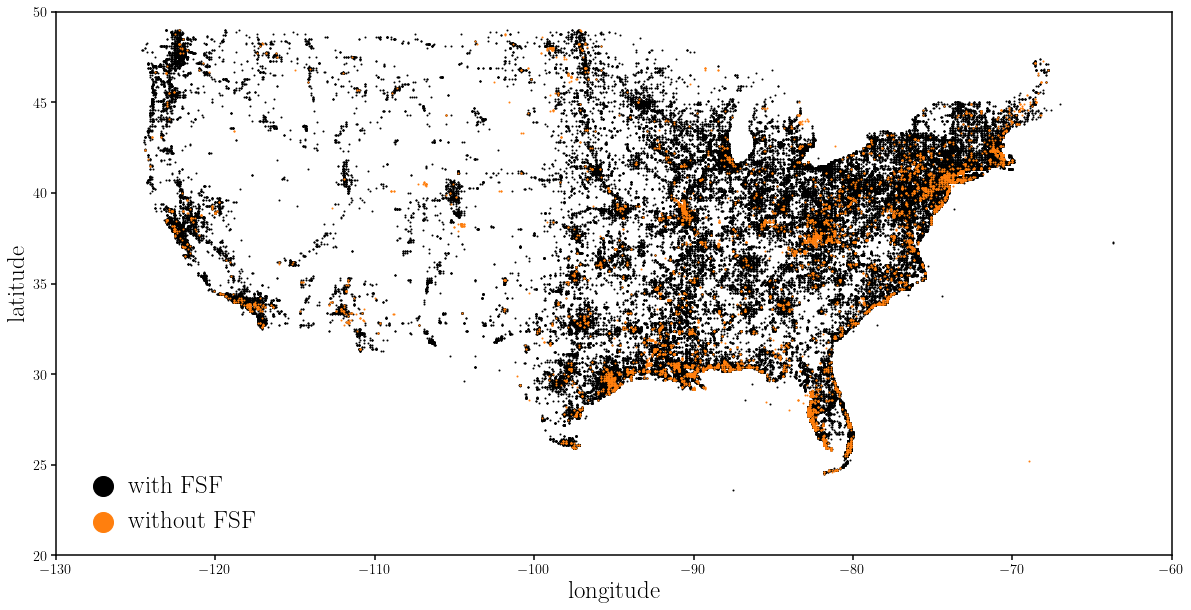

In [12]:
fig = plt.figure(figsize=(20,10))
sub = fig.add_subplot(111)
sub.scatter(comb['longitude'][~comb['count_property'].mask], comb['latitude'][~comb['count_property'].mask], s=1, c='k', rasterized=True, label='with FSF')
sub.scatter(comb['longitude'][comb['count_property'].mask], comb['latitude'][comb['count_property'].mask], s=1, c='C1', rasterized=True, label='without FSF')
sub.legend(loc='lower left', markerscale=20, handletextpad=0., fontsize=25)
sub.set_xlabel('longitude', fontsize=25)
sub.set_xlim(-130., -60)
sub.set_ylabel('latitude', fontsize=25)
sub.set_ylim(20, 50)

(25.0, 35.0)

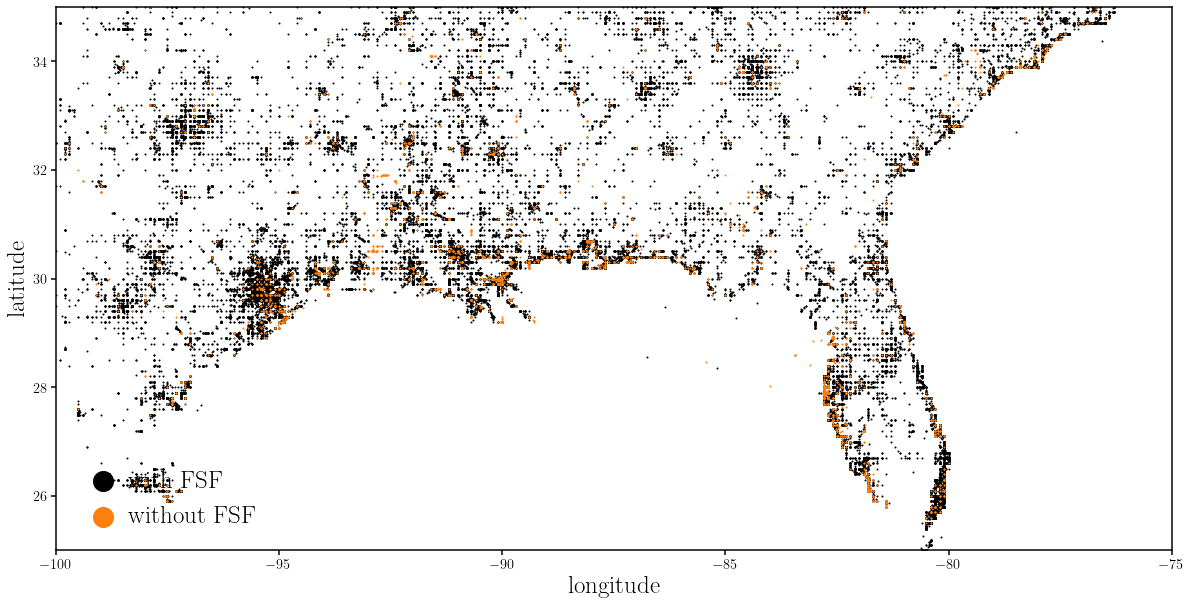

In [13]:
fig = plt.figure(figsize=(20,10))
sub = fig.add_subplot(111)
sub.scatter(comb['longitude'][~comb['count_property'].mask], comb['latitude'][~comb['count_property'].mask], s=1, c='k', rasterized=True, label='with FSF')
sub.scatter(comb['longitude'][comb['count_property'].mask], comb['latitude'][comb['count_property'].mask], s=1, c='C1', rasterized=True, label='without FSF')
sub.legend(loc='lower left', markerscale=20, handletextpad=0., fontsize=25)
sub.set_xlabel('longitude', fontsize=25)
sub.set_xlim(-100., -75)
sub.set_ylabel('latitude', fontsize=25)
sub.set_ylim(25, 35)

## remove entries without FSF data

In [14]:
combined = comb[~comb['count_property'].mask]

In [15]:
combined.write('/Users/chahah/data/noah/fema.zipcode.fsf.csv', format='csv', overwrite=True)